In [ ]:
# UNZIP DATA (Collab)
!unzip dataset-GarbageClassification.zip

In [2]:
import os
import shutil
import random
from tqdm import tqdm

def split_dataset(original_path, output_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    for category in os.listdir(original_path):
        category_path = os.path.join(original_path, category)
        if not os.path.isdir(category_path):
            continue

        images = os.listdir(category_path)
        random.shuffle(images)

        total = len(images)
        train_cut = int(train_ratio * total)
        val_cut = int((train_ratio + val_ratio) * total)

        splits = {
            'train': images[:train_cut],
            'val': images[train_cut:val_cut],
            'test': images[val_cut:]
        }

        for split_name, split_images in splits.items():
            split_dir = os.path.join(output_path, split_name, category)
            os.makedirs(split_dir, exist_ok=True)
            for img in tqdm(split_images, desc=f'{split_name}/{category}', leave=False):
                src = os.path.join(category_path, img)
                dst = os.path.join(split_dir, img)
                shutil.copy2(src, dst)

# Set paths
original_dataset_path = './dataset-GarbageClassification'
output_dataset_path = './split_dataset'

# Split dataset
split_dataset(original_dataset_path, output_dataset_path)


In [3]:
# Import Library Untuk Model VGG16, ResNet50, Preprocessing, Training, dan Plotting
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_pre
from tensorflow.keras.applications.resnet50 import preprocess_input as res_pre
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Bagi masing-masing ke folder dataset hasil split
base_dir = "./split_dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

In [5]:
# Augmentasi data dan preprocessing (untuk VGG16)
train_gen = ImageDataGenerator(
    preprocessing_function=vgg_pre,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_test_gen = ImageDataGenerator(preprocessing_function=vgg_pre)

In [6]:
train_data = train_gen.flow_from_directory(train_dir, target_size=(224,224), batch_size=32, class_mode='categorical')
val_data = val_test_gen.flow_from_directory(val_dir, target_size=(224,224), batch_size=32, class_mode='categorical')
test_data = val_test_gen.flow_from_directory(test_dir, target_size=(224,224), batch_size=32, class_mode='categorical')

Found 10854 images belonging to 12 classes.
Found 3104 images belonging to 12 classes.
Found 1557 images belonging to 12 classes.


In [7]:
train_gen_res = ImageDataGenerator(
    preprocessing_function=res_pre,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_test_gen_res = ImageDataGenerator(preprocessing_function=res_pre)

In [8]:
train_data_res = train_gen_res.flow_from_directory(train_dir, target_size=(224,224), batch_size=32, class_mode='categorical')
val_data_res = val_test_gen_res.flow_from_directory(val_dir, target_size=(224,224), batch_size=32, class_mode='categorical')
test_data_res = val_test_gen_res.flow_from_directory(test_dir, target_size=(224,224), batch_size=32, class_mode='categorical')

Found 10854 images belonging to 12 classes.
Found 3104 images belonging to 12 classes.
Found 1557 images belonging to 12 classes.


In [9]:
num_classes = len(train_data.class_indices)
print("Jumlah kelas:", num_classes)

Jumlah kelas: 12


In [10]:
# VGG MODEL
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in vgg_base.layers[:-4]:
    layer.trainable = False
for layer in vgg_base.layers[-4:]:
    layer.trainable = True

x = Flatten()(vgg_base.output)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
vgg_output = Dense(num_classes, activation='softmax')(x)

vgg_model = Model(inputs=vgg_base.input, outputs=vgg_output)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Model VGG16
vgg_model.summary()

In [12]:
# RESNET50 MODEL
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in resnet_base.layers[:-10]:
    layer.trainable = False
for layer in resnet_base.layers[-10:]:
    layer.trainable = True

y = GlobalAveragePooling2D()(resnet_base.output)
y = Dense(256, activation='relu')(y)
y = BatchNormalization()(y)
y = Dropout(0.3)(y)
res_output = Dense(num_classes, activation='softmax')(y)

resnet_model = Model(inputs=resnet_base.input, outputs=res_output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
# Model ResNet50
resnet_model.summary()

In [14]:
# VGG16 Compile
vgg_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# ResNet50 Compile
resnet_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [16]:
# Training VGG16
print("=== Training VGG16 === ")
history_vgg = vgg_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[reduce_lr, early_stop]
)

=== Training VGG16 === 


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 159s 439ms/step - accuracy: 0.4143 - loss: 2.0543 - val_accuracy: 0.8235 - val_loss: 0.5774 - learning_rate: 1.0000e-05
Epoch 2/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 144s 424ms/step - accuracy: 0.7818 - loss: 0.6911 - val_accuracy: 0.8853 - val_loss: 0.3666 - learning_rate: 1.0000e-05
Epoch 3/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 144s 425ms/step - accuracy: 0.8484 - loss: 0.4792 - val_accuracy: 0.9079 - val_loss: 0.2961 - learning_rate: 1.0000e-05
Epoch 4/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 143s 422ms/step - accuracy: 0.8758 - loss: 0.4032 - val_accuracy: 0.9156 - val_loss: 0.2576 - learning_rate: 1.0000e-05
Epoch 5/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 143s 420ms/step - accuracy: 0.8980 - loss: 0.3134 - val_accuracy: 0.9291 - val_loss: 0.2383 - learning_rate: 1.0000e-05
Epoch 6/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 142s 419ms/step - accuracy: 0.9054 - loss: 0.2940 - val_accuracy: 0.9307 - val_loss: 0.2229 - learning_rate: 1.0000e-05
Epoch 7/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 

In [17]:
# Training ResNet50
print("=== Training ResNet50 ===")
history_res = resnet_model.fit(
    train_data_res,
    validation_data=val_data_res,
    epochs=20,
    callbacks=[reduce_lr, early_stop]
)

=== Training ResNet50 ===
Epoch 1/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 175s 462ms/step - accuracy: 0.3117 - loss: 2.4012 - val_accuracy: 0.7787 - val_loss: 0.7464 - learning_rate: 1.0000e-05
Epoch 2/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 143s 421ms/step - accuracy: 0.7399 - loss: 0.8666 - val_accuracy: 0.8686 - val_loss: 0.4524 - learning_rate: 1.0000e-05
Epoch 3/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 143s 419ms/step - accuracy: 0.8258 - loss: 0.5736 - val_accuracy: 0.8995 - val_loss: 0.3409 - learning_rate: 1.0000e-05
Epoch 4/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 144s 422ms/step - accuracy: 0.8626 - loss: 0.4591 - val_accuracy: 0.9188 - val_loss: 0.2907 - learning_rate: 1.0000e-05
Epoch 5/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 143s 421ms/step - accuracy: 0.8832 - loss: 0.3846 - val_accuracy: 0.9311 - val_loss: 0.2556 - learning_rate: 1.0000e-05
Epoch 6/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 143s 420ms/step - accuracy: 0.8990 - loss: 0.3340 - val_accuracy: 0.9359 - val_loss: 0.2293 - learning_rate: 1.0000e-05
Epoch 7/20
340

In [18]:
# Akses Drive (Collab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# Save Model
folder_name = "DeepLearning_GarbageClassification_Final"
base_path = f"/content/drive/MyDrive/{folder_name}/"

save_path_vgg = base_path + "garbage_classifier_VGG16.keras"
save_path_res = base_path + "garbage_classifier_ResNet50.keras"
vgg_model.save(save_path_vgg)
resnet_model.save(save_path_res)
print(f"\nModels saved to Drive:\n{save_path_vgg}\n{save_path_res}")


Models saved to Drive:
/content/drive/MyDrive/DeepLearning_GarbageClassification_Final/garbage_classifier_VGG16.keras
/content/drive/MyDrive/DeepLearning_GarbageClassification_Final/garbage_classifier_ResNet50.keras


In [20]:
# Plotting
def plot_training_curves_separated(history_vgg, history_res):
  # =========================
  # PLOT UNTUK MODEL VGG16
  # =========================
  plt.figure(figsize=(14, 6))
  plt.suptitle('VGG16')

  plt.subplot(1, 2, 1)
  plt.plot(history_vgg.history['accuracy'], label='VGG16 Train')
  plt.plot(history_vgg.history['val_accuracy'], label='VGG16 Val')
  plt.title('Accuracy: VGG16')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)

  plt.subplot(1, 2, 2)
  plt.plot(history_vgg.history['loss'], label='VGG16 Train')
  plt.plot(history_vgg.history['val_loss'], label='VGG16 Val')
  plt.title('Loss: VGG16')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

  plt.show()

  # =========================
  # PLOT UNTUK MODEL RESNET50
  # =========================
  plt.figure(figsize=(14, 6))
  plt.suptitle('ResNet50')

  plt.subplot(1, 2, 1)
  plt.plot(history_res.history['accuracy'], label='ResNet50 Train')
  plt.plot(history_res.history['val_accuracy'], label='ResNet50 Val')
  plt.title('Accuracy: ResNet50')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)

  plt.subplot(1, 2, 2)
  plt.plot(history_res.history['loss'], label='ResNet50 Train')
  plt.plot(history_res.history['val_loss'], label='ResNet50 Val')
  plt.title('Loss: ResNet50')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

  plt.show()

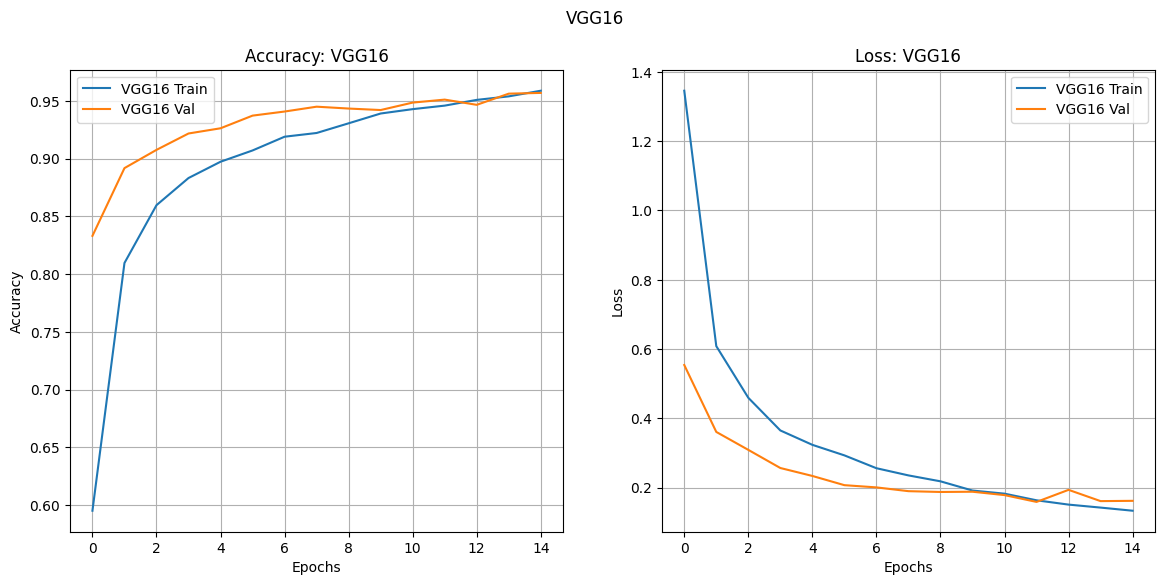

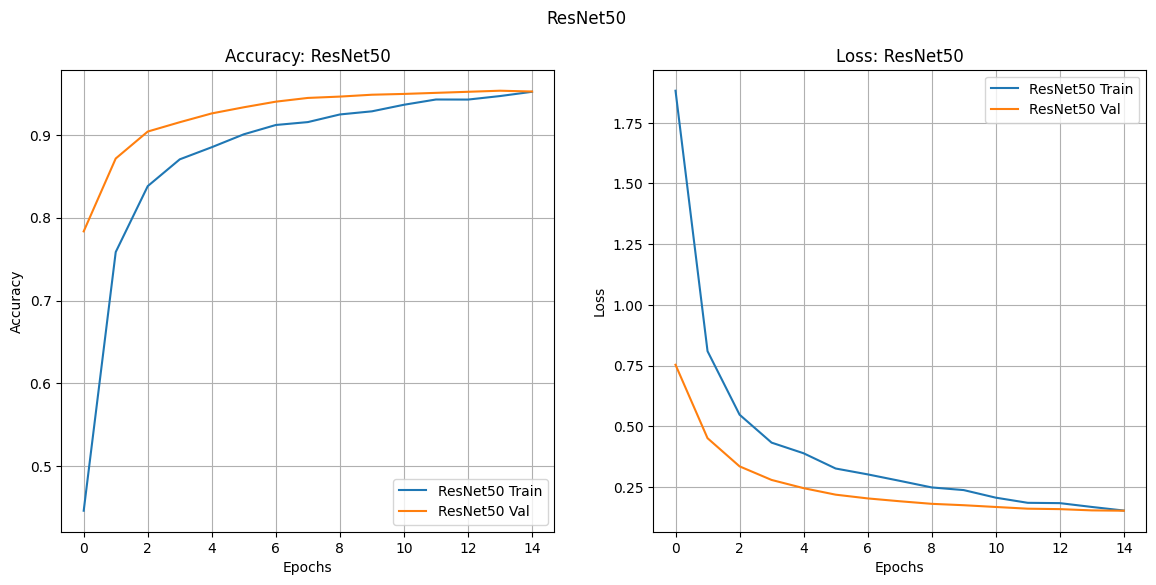

In [ ]:
plot_training_curves_separated(history_vgg, history_res)

## Evaluasi

In [21]:
# Evaluasi model VGG16
loss, acc = vgg_model.evaluate(test_data)
print(f"Test Accuracy: {acc:.2f}")
print(f"Test Loss: {loss:.2f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9461 - loss: 0.2063
Test Accuracy: 0.96
Test Loss: 0.18


In [22]:
# Evaluasi model ResNet50
loss, acc = resnet_model.evaluate(test_data_res)
print(f"Test Accuracy: {acc:.2f}")
print(f"Test Loss: {loss:.2f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.9563 - loss: 0.1538
Test Accuracy: 0.95
Test Loss: 0.16


## Save Dataset yang displit ke drive (untuk dokumentasi)

In [ ]:
import shutil

source_path = '/content/split_dataset'

destination_path = '/content/drive/MyDrive/DeepLearning_GarbageClassification_Final/split_dataset'

try:
    shutil.copytree(source_path, destination_path)
except FileExistsError:
    print(f"Folder sudah ada di Drive.")
except Exception as e:
    print(f"Error. {e}")